In [1]:
import sys, os
sys.path = [os.path.abspath("src")] + sys.path

from config import config
print("NUM_LOOPS =", getattr(config, "NUM_LOOPS", "NO ATTR"))
print("Config file loaded from:", config.__class__.__module__)

NUM_LOOPS = 1
Config file loaded from: config


In [2]:
import sys
sys.path.append(os.path.abspath("src"))

from pathfinding.constraints import is_constrained
print(is_constrained)

<function is_constrained at 0x00000207D9CD40E0>


In [3]:
import sys, os
sys.path = [os.path.abspath("src")] + sys.path  # src가 sys.path 제일 앞으로!

from pathfinding.constraints import is_constrained
print(is_constrained)
from pathfinding.Astar import a_star_multi
print(a_star_multi)

<function is_constrained at 0x00000207D9CD40E0>
<function a_star_multi at 0x00000207F81C8680>



========== 실험 loop 0 ==========


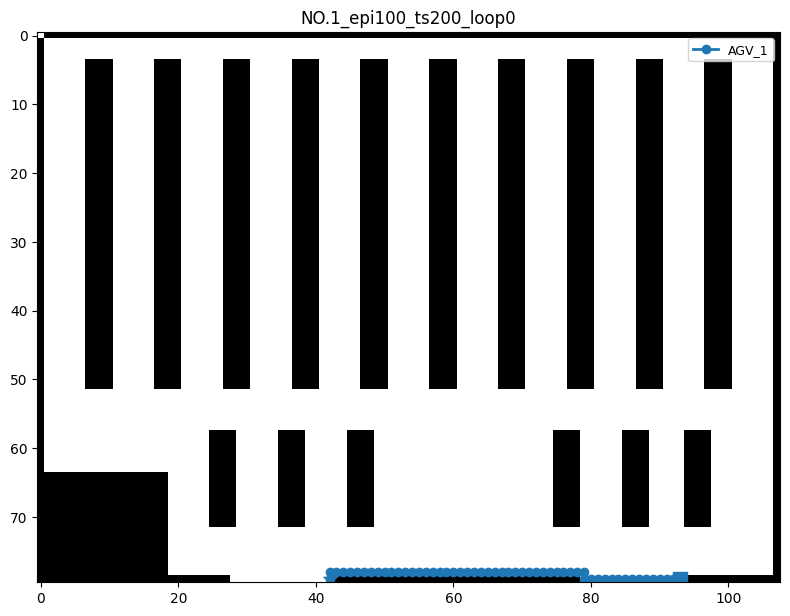

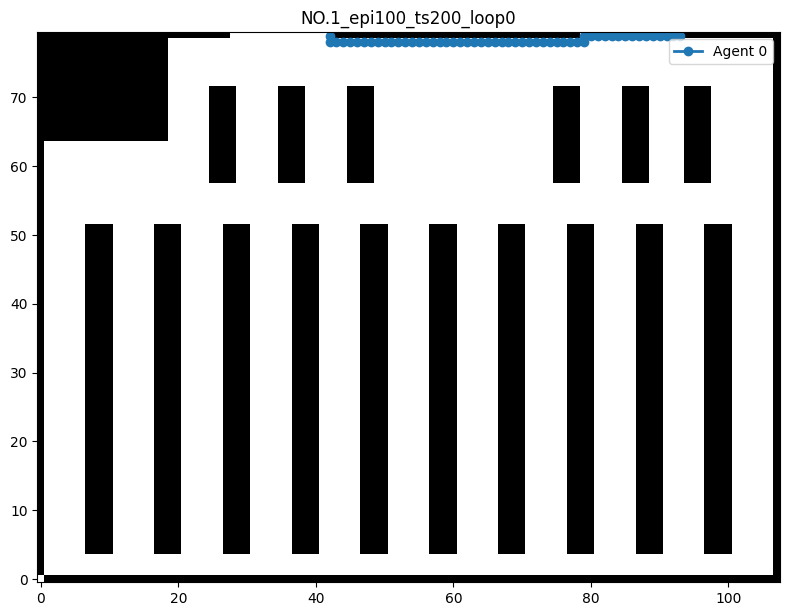

Loop 0 저장 완료: C:\Users\sj123\WMSProject\AI\MAPF-CBS\results\NO.1_epi100_ts200_loops1_loop0\stat_epi100_ts200_loops1_loop0.csv, C:\Users\sj123\WMSProject\AI\MAPF-CBS\results\NO.1_epi100_ts200_loops1_loop0\fig_epi100_ts200_loops1_loop0.png, C:\Users\sj123\WMSProject\AI\MAPF-CBS\results\NO.1_epi100_ts200_loops1_loop0\anim_epi100_ts200_loops1_loop0.gif


In [4]:
import os
os.makedirs(config.RESULTS_DIR, exist_ok=True)
import sys
sys.path.append(os.path.abspath("src")) 
import random
import numpy as np
import time
import pandas as pd
from config import config
from pathfinding.MapLoader import load_map
from pathfinding.Astar import (
    multi_manhattan_heuristics,
    Dijkstra_heuristics,
    a_star_multi,
    get_sum_of_cost
)
from pathfinding.visualize import (
    plot_map_with_paths,
    animate_paths
)
# (CBS 충돌감지)
# from pathfinding.collision import detect_collisions

# 랜덤 시드 고정 
random.seed(config.RANDOM_SEED)
np.random.seed(config.RANDOM_SEED)

def run_single_experiment(loop=0):
    my_map, start, goal, rack_list = load_map(config.MAP_PATH)
    start_locs = [start] * config.N_AGENTS
    goal_locs = [goal] * config.N_AGENTS
    meta_agent = list(range(config.N_AGENTS))

    # 휴리스틱 테이블 생성 (config 옵션으로 분기)
    if config.HEURISTIC_TYPE == "manhattan":
        goals_dict = {i: goal_locs[i] for i in meta_agent}
        h_values = multi_manhattan_heuristics(my_map, goals_dict)
    elif config.HEURISTIC_TYPE == "dijkstra":
        h_values = {i: Dijkstra_heuristics(my_map, goal_locs[i]) for i in meta_agent}
    else:
        raise ValueError(f"Unknown heuristic type: {config.HEURISTIC_TYPE}")

    constraints = getattr(config, "CONSTRAINTS", [])

    t0 = time.time()
    paths = a_star_multi(my_map, start_locs, goal_locs, h_values, meta_agent, constraints)
    elapsed = time.time() - t0

    racks = [rack["loc"] for rack in rack_list] if rack_list else None

    # 충돌 정보 추출 (CBS)
    # collisions = detect_collisions(paths) if paths else []
    collisions = []
    sum_cost = get_sum_of_cost(paths) if paths else None
    path_lengths = [len(p) for p in paths] if paths else None

    # 파일명 자동화
    fig_path = config.get_result_path("fig", loop=loop)
    anim_path = config.get_result_path("anim", loop=loop)
    stat_path = config.get_result_path("stat", loop=loop)

    # 시각화 (각각 저장)
    if config.SAVE_FIG:
        plot_map_with_paths(
            my_map, start_locs, goal_locs, paths,
            racks=racks,
            agent_names=config.AGENT_NAMES,
            title=f"{config.EXP_NO}_epi{config.MAX_EPISODES}_ts{config.MAX_TIMESTEP}_loop{loop}",
            save_path=fig_path
        )
    if config.SAVE_ANIMATION:
        animate_paths(
            my_map, paths,
            racks=racks,
            interval=config.ANIMATION_INTERVAL,
            title=f"{config.EXP_NO}_epi{config.MAX_EPISODES}_ts{config.MAX_TIMESTEP}_loop{loop}",
            save_path=anim_path
        )
        
    result = {
        "loop": loop,
        "algo_name": "AStar",  # or "CBS"
        "map_file": config.MAP_PATH,
        "n_agents": config.N_AGENTS,
        "agent_names": str(config.AGENT_NAMES),
        "start_locs": str(start_locs),
        "goal_locs": str(goal_locs),
        "heuristic_type": config.HEURISTIC_TYPE,
        "random_seed": config.RANDOM_SEED,
        "success": paths is not None,
        "sum_cost": sum_cost,
        "avg_path_length": (sum(path_lengths)/len(path_lengths)) if path_lengths else None,
        "cpu_time": elapsed,
        "n_collisions": len(collisions),
        "collisions": str(collisions),
        "fig_file": fig_path,
        "animation_file": anim_path
    }
    
    pd.DataFrame([result]).to_csv(stat_path, index=False)
    print(f"Loop {loop} 저장 완료: {stat_path}, {fig_path}, {anim_path}")

    return result

def main():
    results = []
    for loop in range(config.NUM_LOOPS):
        print(f"\n========== 실험 loop {loop} ==========")
        result = run_single_experiment(loop=loop)
        results.append(result)
        
if __name__ == "__main__":
    main()

In [5]:
print(config.NUM_LOOPS)

1


In [6]:
from IPython.display import Image
Image(filename="results/anim_1_100_200_loop0.gif")

FileNotFoundError: [Errno 2] No such file or directory: 'results/anim_1_100_200_loop0.gif'

In [ ]:
df = pd.read_csv("results/stat_1_100_200.csv")
df.head()